# Visualize mean streamflow at the HRU-level
Needs: 
- Catchment shapefile with HRU delineation
- mizuRoute output `KWTRoutedRunoff`

In [16]:
# modules
import os
import numpy as np
import xarray as xr
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#### Control file handling

In [2]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line:
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Define where to save the figure

In [6]:
# Path and filename
fig_path = read_from_control(controlFolder/controlFile,'visualization_folder')
fig_name = 'mean_annual_streamflow_per_hru_bowAtBanff.png'

# Specify default path if needed
if fig_path == 'default':
    fig_path = make_default_path('visualization') # outputs a Path()
else:
    fig_path = Path(fig_path) # make sure a user-specified path is a Path()
    
# Make the folder if it doesn't exist
fig_path.mkdir(parents=True, exist_ok=True)

#### Get the shapefile with elevation for background plotting

In [9]:
# Intersection of catchment shapefile and DEM; path & name
elev_catchment_path = read_from_control(controlFolder/controlFile,'intersect_dem_path')
elev_catchment_name = read_from_control(controlFolder/controlFile,'intersect_dem_name')

# Specify default path if needed
if elev_catchment_path == 'default':
    elev_catchment_path = make_default_path('shapefiles/catchment_intersection/with_dem') # outputs a Path()
else:
    elev_catchment_path = Path(elev_catchment_path) # make sure a user-specified path is a Path()

In [10]:
# Find the GRU and HRU identifiers
hm_gruid = read_from_control(controlFolder/controlFile,'catchment_shp_gruid')
hm_hruid = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')

#### Get the shapefile with the river network

In [11]:
# River network path & name
river_network_path = read_from_control(controlFolder/controlFile,'river_network_shp_path')
river_network_name = read_from_control(controlFolder/controlFile,'river_network_shp_name')

# Specify default path if needed
if river_network_path == 'default':
    river_network_path = make_default_path('shapefiles/river_network') # outputs a Path()
else:
    river_network_path = Path(river_network_path) # make sure a user-specified path is a Path()

In [37]:
# Find the segment ID
seg_id = read_from_control(controlFolder/controlFile,'river_network_shp_segid')

#### Find the location of the simulations

In [12]:
# mizuRoute simulation path
mizu_output_path = read_from_control(controlFolder/controlFile,'experiment_output_mizuRoute')
experiment_id = read_from_control(controlFolder/controlFile,'experiment_id')

# Specify default path if needed
if mizu_output_path == 'default':
    mizu_output_path = make_default_path('simulations/' + experiment_id + '/mizuRoute') # outputs a Path()
else:
    mizu_output_path = Path(mizu_output_path) # make sure a user-specified path is a Path()

In [33]:
# Specify the variable of interest
mizu_output_name = 'run1*.nc'
plot_var = 'KWTroutedRunoff'

#### Load the shape and data

In [14]:
# catchment shapefile
shp_catchment = gpd.read_file(elev_catchment_path/elev_catchment_name)

In [15]:
# river shapefile
shp_river = gpd.read_file(river_network_path/river_network_name)

In [24]:
# mizuRoute simulations
mizu_files = [mizu_output_path/file for file in os.listdir(mizu_output_path) if file.endswith('.nc')] # find all files
sim = xr.merge( xr.open_dataset(file) for file in mizu_files) # open all files into a single dataset

#### Add a water year definition

In [26]:
# Define in which month the water year starts
water_year_start = 'Oct' # Assumed to be on the 1st of the month

In [27]:
# Convert month the number 
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
start_month = months.index(water_year_start) + 1 # add 1 to account for 0-based indexing in Python

In [28]:
# Add a water year variable for grouping
sim['water_year'] = sim['time'].dt.year # set initial year

In [29]:
# Overwrite the year for months that are part of the water year that started last calendar year
sim['water_year'].loc[sim['time'].dt.month < start_month] -= 1

#### Preprocessing

In [31]:
# Select only complete water years
complete_water_years = (sim['water_year'] > min(sim['water_year'])) & (sim['water_year'] < max(sim['water_year']))

In [45]:
# Find the mean water-year streamflow per HRU
plot_dat = sim[plot_var].sel(time=complete_water_years).groupby(sim['water_year'].sel(time=complete_water_years)).mean(dim='time').mean(dim='water_year')

In [61]:
# Match the accummulated values to the correct stream IDs in the shapefile
seg_ids_shp = shp_river[seg_id] # stream segment order in shapefile
shp_river['plot_var'] = plot_dat.sel(seg=np.where(sim['reachID'].values == seg_ids_shp.values.astype('int'))[0])

In [43]:
# Create a shapefile with only GRU boundaries for overlay
hm_grus_only = shp_catchment[[hm_gruid,'geometry']] # keep only the gruId and geometry
hm_grus_only = hm_grus_only.dissolve(by=hm_gruid) # Dissolve HRU delineation

In [44]:
# Get the units of our plotting variable
units = sim[plot_var].units

#### Figure

In [73]:
# Set a colormap
cmap_q  = 'Blues'
cmap_elev = 'Greys_r'

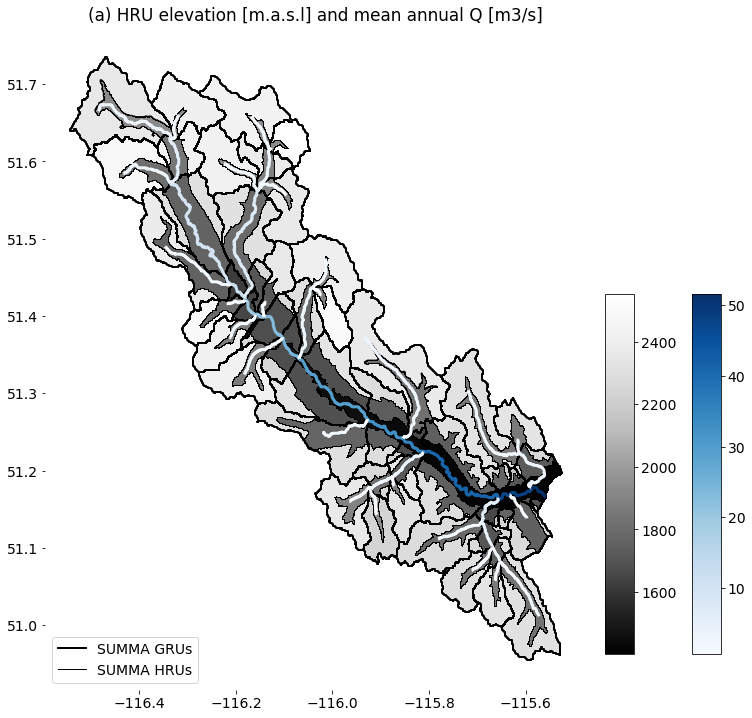

In [90]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
plt.tight_layout()
plt.rcParams.update({'font.size': 14})

# --- mean flow
axId = 0

# Data
shp_catchment.plot(ax=axs[axId], column='elev_mean',edgecolor='k', cmap = cmap_elev, legend=False)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 
shp_river.plot(ax=axs[axId], column='plot_var', cmap=cmap_q,linewidth=3)

# Custom colorbars
cax = fig.add_axes([0.46, 0.1, 0.02, 0.5])
vmin,vmax = shp_catchment['elev_mean'].min(),shp_catchment['elev_mean'].max()
sm = plt.cm.ScalarMappable(cmap=cmap_elev, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

cax = fig.add_axes([0.52, 0.1, 0.02, 0.5])
vmin,vmax = shp_river['plot_var'].min(),shp_river['plot_var'].max()
sm = plt.cm.ScalarMappable(cmap=cmap_q, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(a) HRU elevation [m.a.s.l] and mean annual Q [{}]'.format(units));
axs[axId].set_frame_on(False)

# disable second plot for the moment
axs[1].set_visible(False)

# backup for later development
'''
# --- SWE
axId = 1

# Data
shp.plot(ax=axs[axId], column='plot_var',edgecolor='k', cmap = cmap_swe, legend=False);
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Custom colorbar
cax = fig.add_axes([0.96, 0.1, 0.02, 0.5])
vmin,vmax = shp['plot_var'].min(),shp['plot_var'].max()
sm = plt.cm.ScalarMappable(cmap=cmap_swe, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

# Chart junk
axs[axId].set_title('(b) Simulated mean maximum water-year Snow Water Equivalent [{}]'.format(units));
axs[axId].set_frame_on(False)
'''

# Save 
plt.savefig(fig_path/fig_name, bbox_inches='tight')